In [16]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import random
import torchvision.transforms.functional as F
from floods.utils.gis import imread
import cv2

In [17]:
FOLDER_PATH = "/home/gabrielidis/These/flood/mmflood/processed_data/val"


In [26]:
random_file = random.choice(os.listdir(FOLDER_PATH + "/sar/"))
print(random_file)
sar = imread(FOLDER_PATH + "/sar/" + random_file)
ground_truth_mask = imread(FOLDER_PATH + "/mask/" + random_file)[0]

VH = sar[0]
VV = sar[1]
ground_truth_mask.shape, sar.shape, VH.shape, VV.shape

EMSR342-3-3_1273_951.tif


((512, 512), (2, 512, 512), (512, 512), (512, 512))

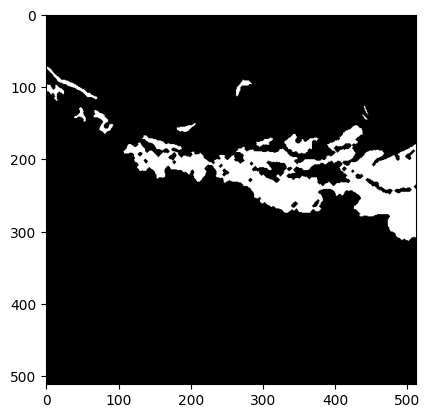

In [27]:
plt.imshow(ground_truth_mask, cmap="gray")

Number of masks :  12


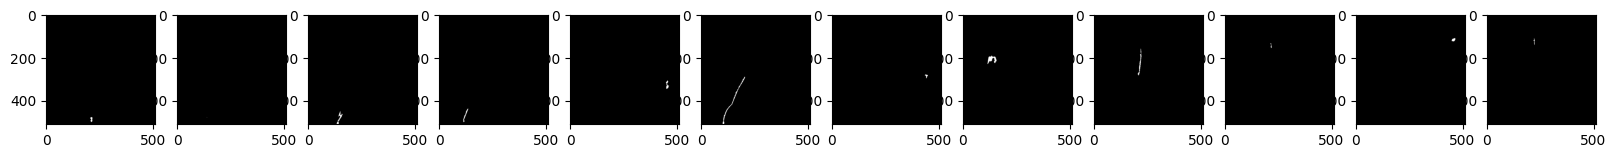

In [20]:
# Convert the mask to a uint8 image (required by OpenCV)
img = (255 * ground_truth_mask).astype('uint8')

# Find the contours in the binary image
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bounding_boxes = [cv2.boundingRect(c) for c in contours]
print("Number of masks : ", len(bounding_boxes) )
# Extract the individual masks from the contours
masks = []
for contour in contours:
    mask = cv2.drawContours(np.zeros_like(img), [contour], 0, 255, -1)
    masks.append(mask)

# Print the resulting masks
fig, axs = plt.subplots(1,len(masks), figsize = (20,20))
for index,mask in enumerate(masks):
    axs[index].imshow(mask, cmap="gray")

In [21]:

ground_truth_mask_rgb = cv2.cvtColor(ground_truth_mask,cv2.COLOR_GRAY2RGB)
for x, y, w, h in bounding_boxes:
    cv2.rectangle(ground_truth_mask_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image
cv2.imshow('Image with bounding boxes', ground_truth_mask_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
sam_list = []

for mask, bounding_boxe in zip(masks,bounding_boxes):
    mask_dict = {
        "segmentation" : (mask ==0),
        "bounding_boxes" : bounding_boxe,
        "area" : None,
        "predicted_iou" : None ,
        "points_coords" : None,
        "stability_core" : None,
        "crop_box" : None,
    }
# Can we fine tune it only considering the segmentation ?